In [1]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, recall_score
import matplotlib.pyplot as plt

In [2]:
#Read CSV file
data = pd.read_csv('.\\Copy_of_sonar_data.csv', delimiter=',', header= None)

In [3]:
#Separate labels and input data turn them into arrays
labels_col = data[60].to_numpy()
labels = np.where(labels_col == 'R', 0, 1)
inputs = data.iloc[:,:60].to_numpy()

In [4]:
#Turn inputs and labels into tensors
X = torch.tensor(inputs, dtype=torch.float)
Y = torch.tensor(labels, dtype=torch.float)

In [5]:
#Split data into train, validation and test data sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify = Y, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, train_size= 0.5, stratify= y_test, random_state= 42)


In [6]:
#Setup the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [7]:
#Build the neural network

class SonarMineDetector(nn.Module):
    def __init__(self,  input_features: int):
        super().__init__()
        self.layer1 = nn.Linear(in_features= input_features, out_features=100)
        self.layer2 = nn.Linear(in_features= 100, out_features=100)
        self.layer3 = nn.Linear(in_features= 100, out_features= 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.relu(out)
        out = self.layer2(out)
        out = self.relu(out)
        out = self.layer3(out)
        return out

model = SonarMineDetector(input_features= 60)
model

SonarMineDetector(
  (layer1): Linear(in_features=60, out_features=100, bias=True)
  (layer2): Linear(in_features=100, out_features=100, bias=True)
  (layer3): Linear(in_features=100, out_features=1, bias=True)
  (relu): ReLU()
)

In [8]:
#Send model and data sets to the device
model.to(device)
x_test.to(device)
y_test.to(device)
x_train.to(device)
y_train.to(device)
x_val.to(device)
y_val.to(device)


tensor([1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1.])

In [9]:
#Fit the model 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#Set the hyper parameters
epochs = 45
learning_rate = 0.01

#Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

#create dictionary to contain mestrcis values
results = {'train loss': [], 'train acc': [], 'val loss': [], 'val acc': [], 'val recall': []}

#Training loop
for epoch in range(epochs):
    avg_loss, avg_acc = 0, 0
    for i in range(len(x_train)):
        model.train()
        
        y_logits = model(x_train[i])
        y_preds = torch.round(torch.sigmoid(y_logits))
        
        
        loss = loss_fn(y_logits.squeeze(), y_train[i])
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        #Model evaluvation
        model.eval()
        with torch.inference_mode():
            
            avg_loss += loss
            avg_acc += accuracy_score(y_train[i].unsqueeze(dim = 0), y_preds)
        
    with torch.inference_mode():
        avg_acc /= len(x_train)
        avg_loss /= len(x_train)
        
        y_val_logits = model(x_val)
        val_loss = loss_fn(y_val_logits.squeeze(), y_val)
        val_acc = accuracy_score(y_val, torch.round(torch.sigmoid(y_val_logits)))
        val_rcl = recall_score(y_val, torch.round(torch.sigmoid(y_val_logits)))
        
        results['train acc'].append(avg_acc)
        results['train loss'].append(avg_loss)
        results['val loss'].append(val_loss)
        results['val acc'].append(val_acc)
        results['val recall'].append(val_rcl)
        
    print(f"Epoch: {epoch + 1} | Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f} | Val_loss: {val_loss:.4f}, Val_acc: {val_acc:.4f}, Val_rcl: {val_rcl:.4f}")
             

Epoch: 1 | Loss: 0.6912, Accuracy: 0.5586 | Val_loss: 0.6877, Val_acc: 0.5484, Val_rcl: 1.0000
Epoch: 2 | Loss: 0.6864, Accuracy: 0.5655 | Val_loss: 0.6856, Val_acc: 0.5484, Val_rcl: 1.0000
Epoch: 3 | Loss: 0.6827, Accuracy: 0.5586 | Val_loss: 0.6841, Val_acc: 0.5484, Val_rcl: 1.0000
Epoch: 4 | Loss: 0.6786, Accuracy: 0.5793 | Val_loss: 0.6825, Val_acc: 0.5484, Val_rcl: 0.9412
Epoch: 5 | Loss: 0.6737, Accuracy: 0.6000 | Val_loss: 0.6803, Val_acc: 0.5484, Val_rcl: 0.9412
Epoch: 6 | Loss: 0.6678, Accuracy: 0.5931 | Val_loss: 0.6774, Val_acc: 0.5806, Val_rcl: 0.9412
Epoch: 7 | Loss: 0.6607, Accuracy: 0.6000 | Val_loss: 0.6735, Val_acc: 0.5806, Val_rcl: 0.9412
Epoch: 8 | Loss: 0.6523, Accuracy: 0.6276 | Val_loss: 0.6689, Val_acc: 0.6452, Val_rcl: 0.9412
Epoch: 9 | Loss: 0.6419, Accuracy: 0.6483 | Val_loss: 0.6633, Val_acc: 0.6452, Val_rcl: 0.8824
Epoch: 10 | Loss: 0.6295, Accuracy: 0.6483 | Val_loss: 0.6568, Val_acc: 0.6129, Val_rcl: 0.8235
Epoch: 11 | Loss: 0.6154, Accuracy: 0.6759 | Val_

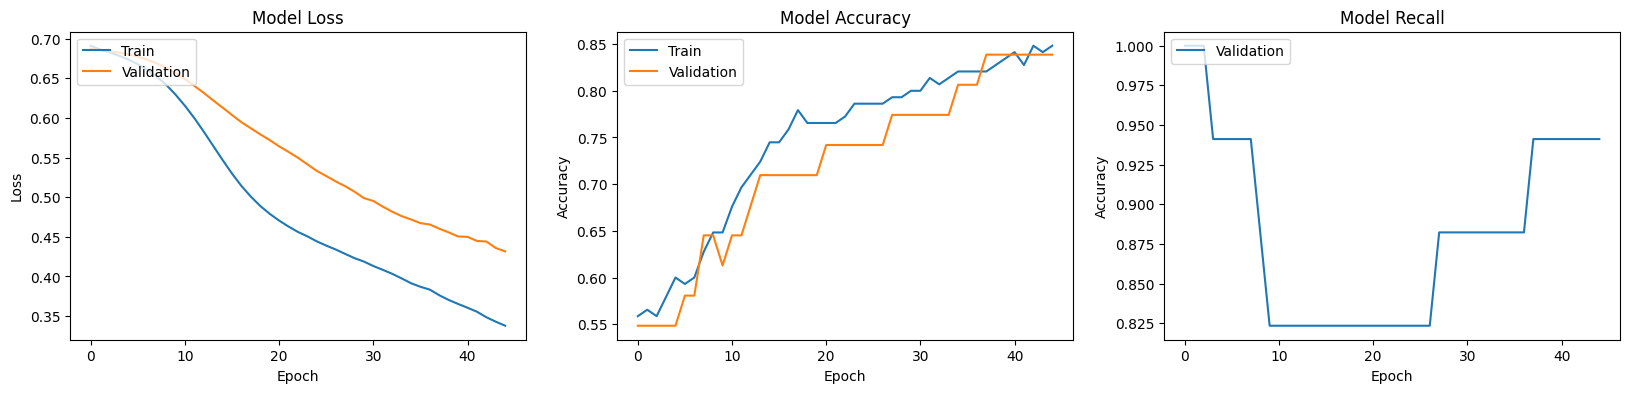

In [10]:
#Plot results
plt.figure(figsize=(20, 4))

plt.subplot(1, 3, 1)
plt.plot(results['train loss'])
plt.plot(results['val loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(results['train acc'])
plt.plot(results['val acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(results['val recall'])
plt.title('Model Recall')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')

plt.show()


In [11]:
#Save the model
torch.save(obj= model.state_dict(), f = 'MineDetectModel_0.pth')

In [12]:
#Make prediction on test set
with torch.inference_mode():
    
    y_test_logits = model(x_test)
    test_acc = accuracy_score(y_test, torch.round(torch.sigmoid(y_test_logits)))
    test_rcl = recall_score(y_test, torch.round(torch.sigmoid(y_test_logits)))

    print(f"Model acuuracy on test set = {test_acc:.4f}\nModel racall on test set = {test_rcl:.4f}")

Model acuuracy on test set = 0.8438
Model racall on test set = 0.9412
